<a href="https://colab.research.google.com/github/SrijithBalachander/Vietnamese_HTR/blob/main/HTR_vn_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vietnamese HTR

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing from Kaggle

Skip if previously done

In [ ]:
!pip install kaggle

In [ ]:
%cd "/content/drive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d bomaich/vietnamese-handwritten-ocr

In [ ]:
!mkdir vietnamese_handwritten_ocr
!unzip -q vietnamese-handwritten-ocr.zip -d vietnamese_handwritten_ocr/

In [ ]:
!ls vietnamese_handwritten_ocr/

In [ ]:
%cd /content

## Importing packages

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [4]:
import os
import cv2
import re

In [5]:
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold,StratifiedKFold 

In [6]:
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing Dataset

In [7]:
char_encoding = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvxyzÀÁÂÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƒƠơƯưạẢảẤấẦầẩẫậắằẳẵặẹẻẽếỀềỂểễỆệỉịọỏỐốỒồổỗộớờỞởỡợụỦủứừửữựỳỷỹ'
print ('the number of characters:', len(char_encoding))
max_len_label = 0

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_encoding.index(char))
        except:
            print(char)
        
    return dig_lst

the number of characters: 147


In [8]:
data_file = "/content/drive/MyDrive/Kaggle/vietnamese_handwritten_ocr/aug_word_data4.csv"
vn_df = pd.read_csv(data_file)

Bản
(array([ 190,    0,   45,    0,   13,    0,   21,    0,   24, 3803]), array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ]))


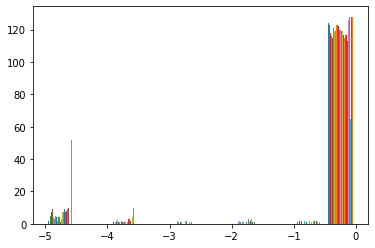

[[250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]
 ...
 [  0.   0.   0. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]]


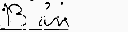

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


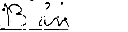

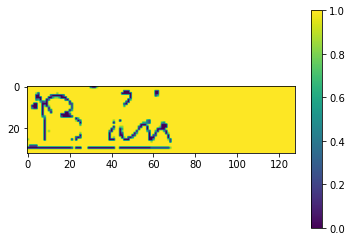

In [9]:
print(vn_df.iloc[0][0])
img1 = np.array(vn_df.iloc[0][1].split(" "), dtype = float)#np.array([float(x) for x in vn_df.iloc[0][1].split(" ")])
img1 = img1.reshape(128, 32)
print(np.histogram(img1))
plt.hist(img1)
plt.show()
print((img1.T + -1*np.min(img1))*50)
cv2_imshow((img1.T + -1*np.min(img1))*50)
print(((img1.T+-1*np.min(img1))/(-1*np.min(img1))))
# cv2_imshow(((img1.T+-1*np.min(img1))/(-1*np.min(img1)))*255)
cv2_imshow(((img1.T/(-1*np.min(img1)))+1)*255)
img1 = (img1.T/(-1*np.min(img1))+1)*255
# plt.imshow(np.asarray(pd.to_numeric(vn_df.iloc[0][1])))
plt.imshow(img1/255.)
# plt.show()
plt.colorbar()

In [10]:
vn_df.dropna(inplace=True)

In [11]:
labels = []
images = []

for i in range(len(vn_df)):
  label = vn_df.iloc[i][0].strip()
  max_len_label = max(len(label), max_len_label)
  labels.append(label)
  img1 = np.array(vn_df.iloc[i][1].split(" "), dtype = float)
  img1 = img1.reshape(128, 32)
  img1 = img1.T/(-1*np.min(img1))+1    ## reverse-standardized and standardized again to suit the problem
  img1 = np.expand_dims(img1, axis=2)
  images.append(img1)

print(np.asarray(images).shape, np.asarray(labels).shape)
print(max_len_label)

(110734, 32, 128, 1) (110734,)
11


## Train-Test Split

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, train_size= 0.90, shuffle = True)
print(len(X_train), len(y_train), len(X_valid), len(y_valid))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size= 0.80, shuffle = True)

images = []
labels = []

99660 99660 11074 11074


In [12]:
y_valid_enc = []
valid_input_len = []
y_valid_len = []

for value in y_valid:
  y_valid_enc.append(encode_to_labels(value))
  y_valid_len.append(len(value))
  valid_input_len.append(31)

print(y_valid[:5])

['nghiệp', 'kẻ', 'đó', 'gắt', '7']


In [13]:
y_train_enc = []
train_input_len = []
y_train_len = []

for value in y_train:
  y_train_enc.append(encode_to_labels(value))
  y_train_len.append(len(value))
  train_input_len.append(31)

print(y_train[:5])

['ra', 'Vũng', 'giải', 'hi', 'Có']


In [ ]:
# test_path = []
# test_label = []
# with open("/content/RWTH.iam_word_gt_final.test.thresh") as test_list:
#   for value in test_list:
#     test_path.append(value.split(",")[0].strip()+".png")
#     test_label.append(value.split(" ",1)[1].strip())

# # print(test_path)

# max_len_label = max(max_len_label,len(max(test_label, key=len)))
# # print(max_len_label)

In [14]:
y_train_padded = pad_sequences(y_train_enc, maxlen=max_len_label, padding='post', value = len(char_encoding))
y_valid_padded = pad_sequences(y_valid_enc, maxlen=max_len_label, padding='post', value = len(char_encoding))

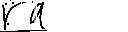

ra


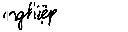

nghiệp


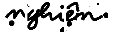

nghiên


In [15]:
cv2_imshow(X_train[0]*255)
print(y_train[0])

cv2_imshow(X_valid[0]*255)
print(y_valid[0])

cv2_imshow(X_test[5]*255)
print(y_test[5])

## Network Architecture

Based on [this](https://arxiv.org/pdf/1507.05717.pdf) paper and [this](https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-1/) blog.

In [16]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_encoding)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [17]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

## CTC Loss function

In [18]:
labels = Input(name='the_labels', shape=[max_len_label], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

## Training and Validation

In [19]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
# filepath="best_model.hdf5"
filepath = "/content/drive/MyDrive/Kaggle/vn_htr_best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [20]:
X_train = np.array(X_train)
train_input_len = np.array(train_input_len)
y_train_len = np.array(y_train_len)

X_valid = np.array(X_valid)
valid_input_len = np.array(valid_input_len)
y_valid_len = np.array(y_valid_len)

In [21]:
X_test = np.array(X_test)

In [28]:
def train_initial(model,_epochs=10, _batch_size=256):
  model.fit(x=[X_train, y_train_padded, train_input_len, y_train_len], y=np.zeros(len(train_input_len)), batch_size=_batch_size, epochs = _epochs, validation_data = ([X_valid, y_valid_padded, valid_input_len, y_valid_len], [np.zeros(len(valid_input_len))]), verbose = 1, callbacks = callbacks_list)

def continue_training(model):
  model.load_weights("/content/drive/MyDrive/Kaggle/vn_htr_best_model.hdf5")
  train_initial(model)

def transfer_learning(model):
  model.load_weights("/content/drive/MyDrive/IAM_dataset/best_model.hdf5", by_name=True, skip_mismatch=True)
  train_initial(model, _batch_size=64)

In [29]:
transfer_learning(model)

Epoch 1/10
1246/1246 [==============================] - ETA: 0s - loss: 8.0001
Epoch 1: val_loss improved from inf to 4.87941, saving model to /content/drive/MyDrive/Kaggle/vn_htr_best_model.hdf5
1246/1246 [==============================] - 144s 98ms/step - loss: 8.0001 - val_loss: 4.8794
Epoch 2/10
1246/1246 [==============================] - ETA: 0s - loss: 3.7896
Epoch 2: val_loss improved from 4.87941 to 3.15803, saving model to /content/drive/MyDrive/Kaggle/vn_htr_best_model.hdf5
1246/1246 [==============================] - 114s 92ms/step - loss: 3.7896 - val_loss: 3.1580
Epoch 3/10
1246/1246 [==============================] - ETA: 0s - loss: 2.6399
Epoch 3: val_loss improved from 3.15803 to 2.51062, saving model to /content/drive/MyDrive/Kaggle/vn_htr_best_model.hdf5
1246/1246 [==============================] - 115s 92ms/step - loss: 2.6399 - val_loss: 2.5106
Epoch 4/10
1246/1246 [==============================] - ETA: 0s - loss: 2.1332
Epoch 4: val_loss improved from 2.51062 to 

In [ ]:
!nvidia-smi

In [ ]:
!ps -aux|grep python

## Testing

In [ ]:
act_model.load_weights("/content/drive/MyDrive/Kaggle/vn_htr_best_model.hdf5")

prediction = act_model.predict(X_test)

out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],greedy=True)[0][0])

predicted_labels = ["".join([char_encoding[x] for x in img if x != -1]) for img in out]
# print(["".join([char_encoding[x] for x in img if x != -1]) for img in out])
# print(predicted_labels[:10])

In [ ]:
for i in range(10):
  cv2_imshow(X_test[i]*255)
  print(y_test[i])
  print(predicted_labels[i])